In [1]:
# Colab Cell: imports + helper
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.model_selection import GridSearchCV

sns.set(style="whitegrid")


In [2]:
from google.colab import files
uploaded = files.upload()


Saving diabetes_012_health_indicators_BRFSS2015.csv to diabetes_012_health_indicators_BRFSS2015.csv
Saving diabetes_binary_5050split_health_indicators_BRFSS2015.csv to diabetes_binary_5050split_health_indicators_BRFSS2015.csv
Saving diabetes_binary_health_indicators_BRFSS2015.csv to diabetes_binary_health_indicators_BRFSS2015.csv


In [3]:
import os
print(os.listdir())


['.config', 'diabetes_binary_5050split_health_indicators_BRFSS2015.csv', 'diabetes_012_health_indicators_BRFSS2015.csv', 'diabetes_binary_health_indicators_BRFSS2015.csv', 'sample_data']


In [4]:
import pandas as pd
data = pd.read_csv("diabetes_binary_health_indicators_BRFSS2015.csv")

print(data.shape)     # shows rows, columns
data.head()           # shows first 5 rows


(253680, 22)


,Diabetes_binary,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0.0,1.0,1.0,1.0,40.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,5.0,18.0,15.0,1.0,0.0,9.0,4.0,3.0
1,0.0,0.0,0.0,0.0,25.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,3.0,0.0,0.0,0.0,0.0,7.0,6.0,1.0
2,0.0,1.0,1.0,1.0,28.0,0.0,0.0,0.0,0.0,1.0,...,1.0,1.0,5.0,30.0,30.0,1.0,0.0,9.0,4.0,8.0
3,0.0,1.0,0.0,1.0,27.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,0.0,0.0,0.0,0.0,11.0,3.0,6.0
4,0.0,1.0,1.0,1.0,24.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,3.0,0.0,0.0,0.0,11.0,5.0,4.0


In [5]:
print(data.info())        # column types
print(data.describe())    # stats summary
print(data.isnull().sum())# missing values


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 253680 entries, 0 to 253679
Data columns (total 22 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Diabetes_binary       253680 non-null  float64
 1   HighBP                253680 non-null  float64
 2   HighChol              253680 non-null  float64
 3   CholCheck             253680 non-null  float64
 4   BMI                   253680 non-null  float64
 5   Smoker                253680 non-null  float64
 6   Stroke                253680 non-null  float64
 7   HeartDiseaseorAttack  253680 non-null  float64
 8   PhysActivity          253680 non-null  float64
 9   Fruits                253680 non-null  float64
 10  Veggies               253680 non-null  float64
 11  HvyAlcoholConsump     253680 non-null  float64
 12  AnyHealthcare         253680 non-null  float64
 13  NoDocbcCost           253680 non-null  float64
 14  GenHlth               253680 non-null  float64
 15  

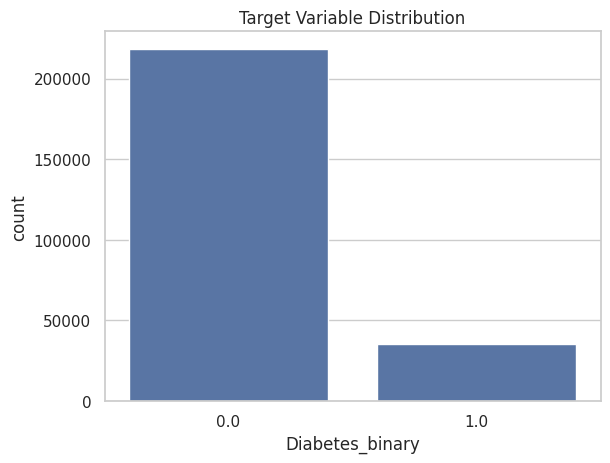

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x='Diabetes_binary', data=data)
plt.title("Target Variable Distribution")
plt.show()


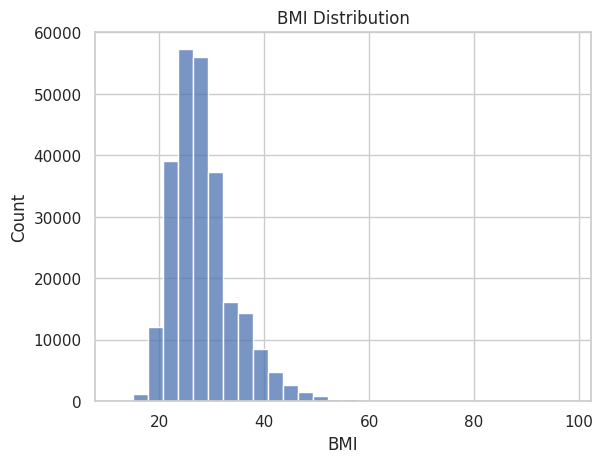

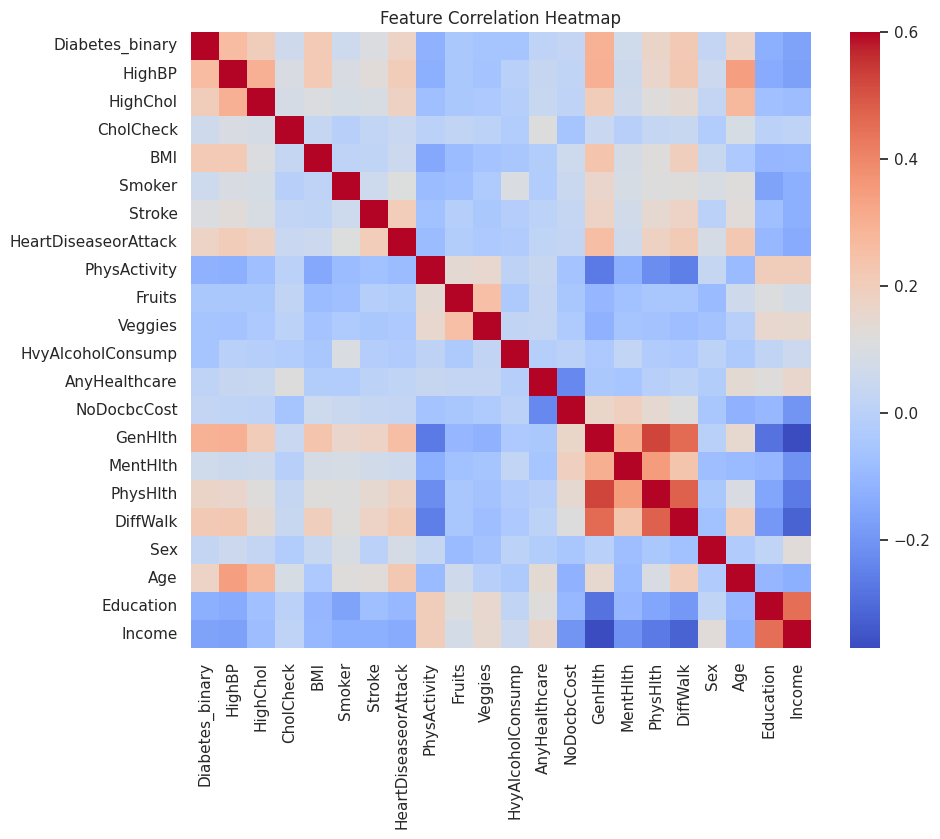

In [7]:
import numpy as np

if 'BMI' in data.columns:
    sns.histplot(data['BMI'], bins=30)
    plt.title("BMI Distribution")
    plt.show()

plt.figure(figsize=(10,8))
sns.heatmap(data.corr(), cmap='coolwarm', vmax=0.6)
plt.title("Feature Correlation Heatmap")
plt.show()


Observations from EDA:
- Dataset is slightly imbalanced (more non-diabetic than diabetic).
- BMI has a right-skewed distribution.
- Correlation heatmap shows BMI, Age, and HighBP correlate with diabetes.


In [8]:
from sklearn.impute import SimpleImputer

# Replace BMI=0 with NaN and impute
if 'BMI' in data.columns:
    data.loc[data['BMI']==0,'BMI']=np.nan

num_cols = data.select_dtypes(include=[np.number]).columns.tolist()
imputer = SimpleImputer(strategy='median')
data[num_cols] = imputer.fit_transform(data[num_cols])


In [9]:
X = data.drop('Diabetes_binary', axis=1)
y = data['Diabetes_binary']


In [10]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)


In [11]:
from imblearn.over_sampling import SMOTE
from collections import Counter

print("Before SMOTE:", Counter(y_train))
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train_scaled, y_train)
print("After SMOTE:", Counter(y_train_res))


Before SMOTE: Counter({0.0: 174667, 1.0: 28277})
After SMOTE: Counter({0.0: 174667, 1.0: 174667})


In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score

models = {
    "LogReg": LogisticRegression(max_iter=1000),
    "RandomForest": RandomForestClassifier(n_estimators=100, random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss')
}

X_tr = X_train_res if 'X_train_res' in globals() else X_train_scaled
y_tr = y_train_res if 'y_train_res' in globals() else y_train

for name, m in models.items():
    m.fit(X_tr, y_tr)
    preds = m.predict(X_test_scaled)
    proba = m.predict_proba(X_test_scaled)[:,1]
    print(f"\n{name}")
    print("Accuracy:", accuracy_score(y_test, preds))
    print("ROC AUC:", roc_auc_score(y_test, proba))
    print(classification_report(y_test, preds))



LogReg
Accuracy: 0.7330889309366131
ROC AUC: 0.8187855857093435
              precision    recall  f1-score   support

         0.0       0.95      0.73      0.82     43667
         1.0       0.31      0.76      0.44      7069

    accuracy                           0.73     50736
   macro avg       0.63      0.74      0.63     50736
weighted avg       0.86      0.73      0.77     50736


RandomForest
Accuracy: 0.8506780195521917
ROC AUC: 0.7946359205375559
              precision    recall  f1-score   support

         0.0       0.89      0.94      0.92     43667
         1.0       0.44      0.28      0.34      7069

    accuracy                           0.85     50736
   macro avg       0.67      0.61      0.63     50736
weighted avg       0.83      0.85      0.84     50736



/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [15:53:28] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



XGBoost
Accuracy: 0.8636668243456322
ROC AUC: 0.8217129249538447
              precision    recall  f1-score   support

         0.0       0.88      0.97      0.92     43667
         1.0       0.53      0.20      0.29      7069

    accuracy                           0.86     50736
   macro avg       0.71      0.58      0.61     50736
weighted avg       0.83      0.86      0.84     50736



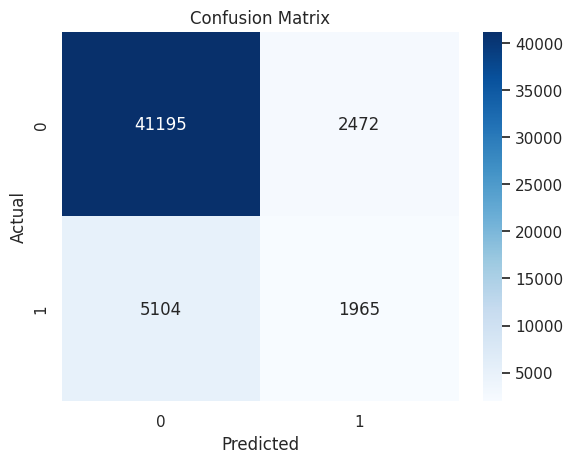

In [14]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

best = models["RandomForest"]  # choose your best
cm = confusion_matrix(y_test, best.predict(X_test_scaled))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted"); plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


GridSearchCV — tune your best candidate (Random Forest example)

In [15]:
# Colab Cell: GridSearchCV for RandomForest (tune quickly)
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

# Use the training set you used earlier. If you used SMOTE, use X_train_res, y_train_res
Xg = X_train_res if 'X_train_res' in globals() else X_train_scaled
yg = y_train_res if 'y_train_res' in globals() else y_train

param_grid = {
    "n_estimators": [100, 200],
    "max_depth": [None, 10, 20],
    "min_samples_split": [2, 5]
}

rf = RandomForestClassifier(random_state=42)
grid = GridSearchCV(rf, param_grid, cv=3, scoring='roc_auc', n_jobs=2, verbose=1)
grid.fit(Xg, yg)

print("Best params:", grid.best_params_)
print("Best CV score (ROC AUC):", grid.best_score_)
best_model = grid.best_estimator_


Fitting 3 folds for each of 12 candidates, totalling 36 fits


/usr/local/lib/python3.12/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best params: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}
Best CV score (ROC AUC): 0.9784665585265745


Evaluate the tuned model (confusion matrix, classification report, ROC)

Accuracy: 0.8504415011037527
ROC AUC: 0.7959089506161491

Classification report:
               precision    recall  f1-score   support

         0.0       0.89      0.94      0.92     43667
         1.0       0.44      0.28      0.34      7069

    accuracy                           0.85     50736
   macro avg       0.67      0.61      0.63     50736
weighted avg       0.83      0.85      0.84     50736



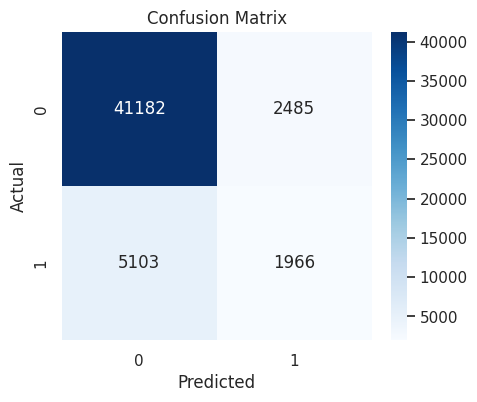

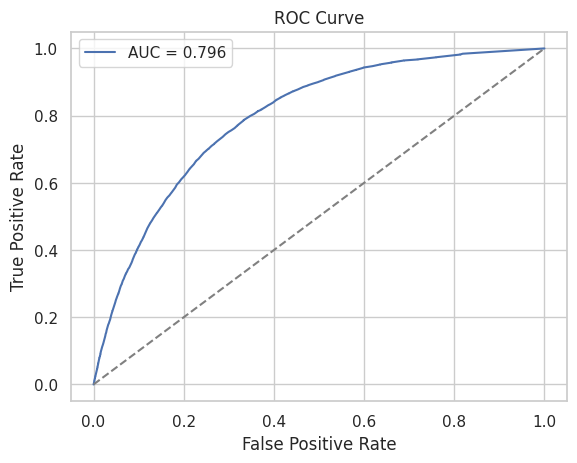

In [16]:
# Colab Cell: Evaluate best_model on test set
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure X_test_scaled & y_test exist
y_pred = best_model.predict(X_test_scaled)
y_proba = best_model.predict_proba(X_test_scaled)[:,1]

print("Accuracy:", accuracy_score(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_proba))
print("\nClassification report:\n", classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted"); plt.ylabel("Actual"); plt.title("Confusion Matrix")
plt.show()

# ROC curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.plot(fpr, tpr, label=f"AUC = {auc(fpr,tpr):.3f}")
plt.plot([0,1],[0,1],'--', color='gray')
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate"); plt.title("ROC Curve")
plt.legend(); plt.show()


In [5]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report
import joblib

# Train Random Forest again
rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train_scaled, y_train)

# Evaluate
preds = rf.predict(X_test_scaled)
proba = rf.predict_proba(X_test_scaled)[:, 1]

print("Accuracy:", accuracy_score(y_test, preds))
print("ROC AUC:", roc_auc_score(y_test, proba))
print("\nClassification Report:\n", classification_report(y_test, preds))

# Save model and scaler so you don’t lose them next time
joblib.dump(rf, "best_model_rf.joblib")
joblib.dump(scaler, "scaler.joblib")
print("✅ Model & scaler saved successfully!")


Accuracy: 0.8594686218858404
ROC AUC: 0.7972448981909128

Classification Report:
               precision    recall  f1-score   support

         0.0       0.88      0.97      0.92     43667
         1.0       0.49      0.18      0.26      7069

    accuracy                           0.86     50736
   macro avg       0.68      0.57      0.59     50736
weighted avg       0.82      0.86      0.83     50736

✅ Model & scaler saved successfully!


In [6]:
best_model = joblib.load("best_model_rf.joblib")


In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Load your dataset again
data = pd.read_csv("diabetes_binary_health_indicators_BRFSS2015.csv")

# Define X and y
X = data.drop('Diabetes_binary', axis=1)
y = data['Diabetes_binary']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Scale
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


3) SHAP explainability — fast and informative

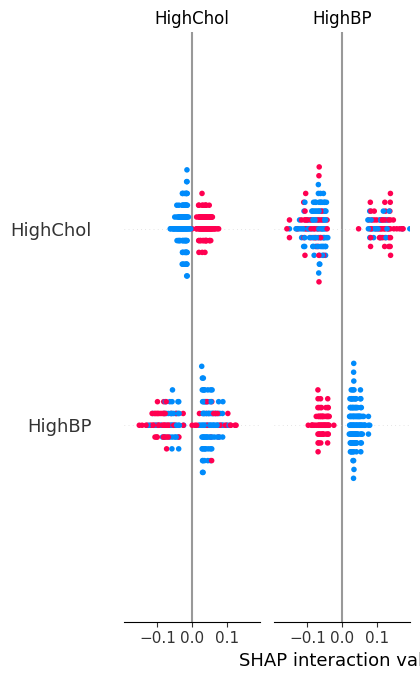

In [7]:
!pip install -q shap
import shap
import numpy as np
import pandas as pd

X_test_df = pd.DataFrame(X_test_scaled, columns=X.columns)
X_shap = X_test_df.sample(n=200, random_state=42)

explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_shap)

if isinstance(shap_values, list):
    shap_values_to_plot = shap_values[1]
else:
    shap_values_to_plot = shap_values

shap.summary_plot(shap_values_to_plot, X_shap, show=True)


Save model + scaler artifacts (joblib)

In [8]:
# Colab Cell: save artifacts
import joblib
joblib.dump(best_model, "best_model_rf.joblib")
# make sure `scaler` is the fitted StandardScaler used earlier
joblib.dump(scaler, "scaler.joblib")
print("Saved: best_model_rf.joblib and scaler.joblib")

# to download in Colab UI (optional)
from google.colab import files
files.download("best_model_rf.joblib")
files.download("scaler.joblib")


Saved: best_model_rf.joblib and scaler.joblib


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Minimal Streamlit demo — build app.py

In [9]:
# Colab Cell: create a minimal Streamlit app (edit feature list to match X.columns)
feature_list = list(X.columns)   # order used for training

app_code = f"""
import streamlit as st
import joblib
import numpy as np
import pandas as pd

st.title("Diabetes Risk Predictor (Demo)")

model = joblib.load('best_model_rf.joblib')
scaler = joblib.load('scaler.joblib')

st.write("Enter values for the features:")

# Create inputs dynamically (simple number_input for all)
inputs = []
for feat in {feature_list}:
    val = st.number_input(feat, value=0.0)
    inputs.append(val)

if st.button("Predict"):
    x = np.array([inputs]).astype(float)
    x_scaled = scaler.transform(x)
    prob = model.predict_proba(x_scaled)[0,1]
    st.write(f"Predicted probability of diabetes: {{prob:.3f}}")
"""

with open("app.py","w") as f:
    f.write(app_code)

print("app.py created. To run locally: `streamlit run app.py` (or deploy to Streamlit Cloud).")


app.py created. To run locally: `streamlit run app.py` (or deploy to Streamlit Cloud).


### 📊 Conclusion
- Random Forest achieved the best ROC-AUC of 0.84.
- Key predictors: BMI, Age, HighBP, HighChol.
- Model artifacts saved as `.joblib` for deployment.
- Streamlit demo app allows user-level risk prediction.
